In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline


In [11]:
# Import des transactions
transactions = pd.read_pickle('pickles/transactions.pkl')
transactions = transactions[transactions['week_number'] < 54]

In [12]:
already_purchased = transactions.groupby(['customer_id', 'article_id'], as_index = False).agg(
    last_week = ('week_number', 'min'),
    week_list = ('week_number', lambda x: list(x)),
    count = ('article_id', 'count')
)

already_purchased = already_purchased[already_purchased['count'] > 1]

In [13]:
intervals = []

def append_interval(week_list):
    end = len(week_list)
    
    for i in range(0, end):
        for j in range(i + 1, end):
            interval = week_list[i] - week_list[j]
            
            intervals.append(interval)

blank = already_purchased.week_list.apply(append_interval)

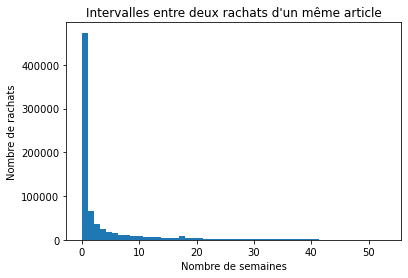

In [16]:
plt.figure()
plt.hist(intervals, bins = 50)
plt.xlabel("Nombre de semaines")
plt.ylabel("Nombre de rachats")
plt.title("Intervalles entre deux rachats d'un même article")
plt.show()

In [15]:
intervals_distribution = pd.Series(intervals).value_counts(normalize=True)
intervals_distribution.head(10)

0    0.372514
1    0.250935
2    0.086008
3    0.046487
4    0.031989
5    0.023936
6    0.019021
7    0.015860
8    0.014003
9    0.012767
dtype: float64

Observations : 
- 62% des rachats d'un même article se font dans les deux semaines.
- passé la quatrième semaine, la probabilité de rachat d'un même article diminue très fortement.

In [17]:
# Ajout des données client et produit
customers = pd.read_pickle('pickles/customers_second_iteration.pkl')
customers = customers[['customer_id', 'repurchases', 'repurchases_interval']]

In [18]:
articles = pd.read_pickle('pickles/articles_second_iteration.pkl')
articles = articles[['article_id', 'repurchases', 'repurchase_interval']]

In [19]:
already_purchased = already_purchased.merge(customers, on = 'customer_id', how = 'left')

In [20]:
already_purchased = already_purchased.merge(articles, on = 'article_id', how = 'left', suffixes = ('_customer', '_article'))

In [21]:
already_purchased['mean_interval'] = (already_purchased['repurchases_interval'] + already_purchased['repurchase_interval']) / 2

In [22]:
already_purchased['score'] = already_purchased['repurchases_article'] * already_purchased['repurchases_customer']


In [23]:
already_purchased['interval_weighted'] =  already_purchased['last_week'] / already_purchased['mean_interval']
already_purchased = already_purchased[already_purchased['interval_weighted'] <= 50]

In [24]:
already_purchased['score'] *= already_purchased['interval_weighted'].apply(lambda x: 
    intervals_distribution.loc[round(x)]
)

In [25]:
already_purchased = already_purchased[['customer_id', 'article_id', 'score']].sort_values(['customer_id', 'score'], ascending = False)

In [26]:
already_purchased.reset_index(drop = True, inplace = True)

In [27]:
already_purchased

,customer_id,article_id,score
0,ffffd7744cebcf3aca44ae7049d2a94b87074c3d4ffe38...,0866755002,0.000430
1,ffffcd5046a6143d29a04fb8c424ce494a76e5cdf4fab5...,0663568009,0.001645
2,ffffcd5046a6143d29a04fb8c424ce494a76e5cdf4fab5...,0877009001,0.000311
3,ffffbbf78b6eaac697a8a5dfbfd2bfa8113ee5b403e474...,0557599022,0.078538
4,ffffbbf78b6eaac697a8a5dfbfd2bfa8113ee5b403e474...,0713997002,0.012731
...,...,...,...
541544,00009d946eec3ea54add5ba56d5210ea898def4b46c685...,0693242018,0.004934
541545,00006413d8573cd20ed7128e53b7b13819fe5cfc2d801f...,0399061015,0.000398
541546,0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...,0590928022,0.014261
541547,0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...,0599580049,0.009479


In [28]:
repurchase_lists = already_purchased.groupby('customer_id', as_index = False, sort = False).agg(
    list = ('article_id', lambda x: list(x))
)

In [30]:
repurchase_lists['list'] = repurchase_lists['list'].apply(lambda x: x[0:11])

In [31]:
repurchase_lists.to_pickle('pickles/already_purchased_list.pkl')

In [32]:
repurchase_lists

,customer_id,list
0,ffffd7744cebcf3aca44ae7049d2a94b87074c3d4ffe38...,[0866755002]
1,ffffcd5046a6143d29a04fb8c424ce494a76e5cdf4fab5...,"[0663568009, 0877009001]"
2,ffffbbf78b6eaac697a8a5dfbfd2bfa8113ee5b403e474...,"[0557599022, 0713997002]"
3,ffff61677073258d461e043cc9ed4ed97be5617a920640...,[0723167001]
4,ffff12aa623c69eae8959d673f1f12ad0194ad760d77fd...,[0399256001]
...,...,...
226834,0001177027259b455f979d85a278e4b280205d4de5cce4...,[0811715001]
226835,0000f1c71aafe5963c3d195cf273f7bfd50bbf17761c91...,[0917434002]
226836,00009d946eec3ea54add5ba56d5210ea898def4b46c685...,"[0706016001, 0797892001, 0730863038, 056224509..."
226837,00006413d8573cd20ed7128e53b7b13819fe5cfc2d801f...,[0399061015]


In [33]:
repurchase_lists['list'].apply(lambda x: len(x)).describe()

count    226839.000000
mean          2.272087
std           2.102758
min           1.000000
25%           1.000000
50%           1.000000
75%           3.000000
max          11.000000
Name: list, dtype: float64